<a href="https://colab.research.google.com/github/AnastasiiaX/NewYorkTimes_unsupervised_learning/blob/main/Unsupervised_learning_The_NYT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Authors:

Anastasiia Kosareva

Luis Rheinert

The idea of the project is the same like in project plan, but i little bit modified. In the original plan, we wanted to analyze the Finnish newspaper using the API as well, but we abandoned this idea because analyzing Finnish text is much more difficult than English due to its diversity. So we settled on the idea of ​​analyzing the world-famous newspaper The New York Times.

As we all know, journalism should be independent, and the journalist should be unbiased, so that a person can draw conclusions and subject any information to critical evaluation independently. We became interested in whether the articles of such famous newspapers as The NYT contain an emotional background and if so, what is the coloring typical of these articles. We decided to check this on 3 famous politicians: Stubb, Scholz and Putin.

In our project we used 2 methods. The first method is Sentiment Clustering. We use KMeans algorithm to cluster TF-IDF representations of text into three groups. This clustering was performed to group text data based on latent structures in the feature space, likely related to sentiment tendencies. We also applied the VADER Sentiment Intensity Analyzer, a rule-based sentiment analysis tool, to classify the articles as Positive, Negative, or Neutral based on their content.The KMeans clustering acted as a preprocessing or auxiliary step to identify potential sentiment-related groups within the data. This was followed by using VADER to provide explicit sentiment labels to the articles.

The hierarchical clustering was used as a second method. Sentiment scores are subjected to hierarchical clustering (using the Ward method) to group articles based on their sentiment similarity. This method generates dendrograms to visualize how articles cluster hierarchically.

## Step 1 is getting data.


In [ ]:
pip install pynytimes

As always the main step in the begginig is importing libraries.

In [ ]:
import datetime
import pandas as pd
from pynytimes import NYTAPI
import time

There are a lot of articles from users and official documentation from The NYT in internet, how to get started with The NYT API.
We just created an account on the New York Times Developer Platform. Fortunately, this is completely free of charge.
So, in the next code line you can see our API key.

In [ ]:
nyt = NYTAPI("vJbTzhNZAmMKSW9TR3jRyPK6qeYPGfF5", parse_dates=True)

As we alredy told, there is a documentation, how to use API, what kind of data can be collected, parameters for functions etc. Here is a link: https://developer.nytimes.com/

 The NYT API documentation says, that code can display only 10 articles per page and amout of page can be 100. So, max 1000 articles can be analyzed.
 It is very hard to analyze 1000 articles for each of 3 politicians, and our plan A was to use 100 articles for each politician, but something went wrong, and after many hours spent to make it work, we decided to put this idea aside and analyze only 10 articles for each politician. The problem is that each 10 collected articles must be on a separate page. The documentation does not say how to do this, all the methods we tried did not help.

In [ ]:
def fetch_10_articles(query, begin_date, end_date):
    all_articles = []  # List to store articles

    print(f"Fetching up to 10 articles for '{query}'...")

    try:
        # Fetch the articles (limit to 10 results)
        articles = nyt.article_search(
            query=query,
            results=10,  # Fetch up to 10 results
            dates={"begin": begin_date, "end": end_date}
        )

        # Check if articles were found from the newspaper
        if articles:  # Ensure there's a valid check for articles
            all_articles.extend(articles)
            print(f"Found {len(articles)} articles for '{query}'.")
        else:
            print(f"No articles found for '{query}'.")
    except Exception as e:
        print(f"Error fetching articles: {e}")

    return all_articles[:10]  # Return up to 10 articles


# Define the list of politicians and their queries
politicians = ["Putin", "Stubb", "Scholz"]

# Define the date range for articles
begin_date = datetime.datetime(2024, 3, 1)  # Start date, On this day, Stubb became the president of Finland
end_date = datetime.datetime.now()  # End date (current date)

# Fetch and store articles for each politician
for politician in politicians:
    # Fetch articles for the politician
    articles = fetch_10_articles(politician, begin_date, end_date)

    # Check if articles were fetched
    if articles:
        # Convert the articles into a DataFrame
        df = pd.DataFrame(articles)

        # Save the articles to a CSV file named based on the politician's name
        file_name = f"nyt_{politician.replace(' ', '_').lower()}_articles.csv"
        df.to_csv(file_name, index=False)
        print(f"Articles for {politician} saved to {file_name}")
    else:
        print(f"No articles found for {politician}.")

Fetching up to 10 articles for 'Putin'...
Found 10 articles for 'Putin'.
Articles for Putin saved to nyt_putin_articles.csv
Fetching up to 10 articles for 'Stubb'...
Found 10 articles for 'Stubb'.
Articles for Stubb saved to nyt_stubb_articles.csv
Fetching up to 10 articles for 'Scholz'...
Found 10 articles for 'Scholz'.
Articles for Scholz saved to nyt_scholz_articles.csv


Now, we have 3 data frames with 10 articles for each president.

In [ ]:
df_putin = pd.read_csv('nyt_putin_articles.csv')
df_scholz = pd.read_csv('nyt_scholz_articles.csv')
df_stubb = pd.read_csv('nyt_stubb_articles.csv')

print(df_putin.columns)

Index(['abstract', 'web_url', 'snippet', 'lead_paragraph', 'print_section',
       'print_page', 'source', 'multimedia', 'headline', 'keywords',
       'pub_date', 'document_type', 'news_desk', 'section_name',
       'subsection_name', 'byline', 'type_of_material', '_id', 'word_count',
       'uri'],
      dtype='object')


## Step 2 is Text Preprocessing.
There are some aspects, which we need to complete to prepare our data frames for analyzing:
- Stop words removing
- Punctuation, numbers and special characters removing
- HTML tags removing
- Converting text to lowercase
- Text tokenizing

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Punctuation, numbers and special characters removing
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # HTML tags removing
    text = BeautifulSoup(text, "html.parser").get_text()

    # Tokenizing
    tokens = word_tokenize(text)

    # Remove stopwords removing
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Join the tokens back into a string
    processed_text = " ".join(tokens)
    return processed_text

# Apply preprocessing to all articles in your DataFrame
df_putin['processed_text'] = df_putin['snippet'].apply(preprocess_text)
df_scholz['processed_text'] = df_scholz['snippet'].apply(preprocess_text)
df_stubb['processed_text'] = df_stubb['snippet'].apply(preprocess_text)

## Step 3 is Vectorization
We will use TF-IDF to convert the cleaned text into numerical data for ML modeling.

'In information retrieval, tf–idf (also TF*IDF, TFIDF, TF–IDF, or Tf–idf), short for term frequency–inverse document frequency, is a measure of importance of a word to a document in a collection or corpus, adjusted for the fact that some words appear more frequently in general. Like the bag-of-words model, it models a document as a multiset of words, without word order. It is a refinement over the simple bag-of-words model, by allowing the weight of words to depend on the rest of the corpus.' https://en.wikipedia.org/wiki/Tf%E2%80%93idf

Tutorial: https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

all_articles = pd.concat([df_putin['processed_text'], df_scholz['processed_text'], df_stubb['processed_text']])

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_articles)

## Step 4 is Clustering.
We make it to group together numerical text (our text is represented in numerical format after vectorization). We will cluster the data using K-means algorithm.

'Unsupervised Machine Learning is the process of teaching a computer to use unlabeled, unclassified data and enabling the algorithm to operate on that data without supervision. Without any previous data training, the machine’s job in this case is to organize unsorted data according to parallels, patterns, and variations.

K means clustering, assigns data points to one of the K clusters depending on their distance from the center of the clusters. It starts by randomly assigning the clusters centroid in the space. Then each data point assign to one of the cluster based on its distance from centroid of the cluster. After assigning each point to one of the cluster, new cluster centroids are assigned. This process runs iteratively until it finds good cluster. In the analysis we assume that number of cluster is given in advanced and we have to put points in one of the group.' https://www.geeksforgeeks.org/k-means-clustering-introduction/

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


I the text below, we are using VADER Sentiment analyzer. But what it is?
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed for analyzing social media texts. Vader is a pre-trained sentiment analysis model that provides a sentiment score for a given text.

https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment for each article
def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Assuming X is TF-IDF matrix, we are using 3 clusters, because the idea is to assign each word to one of 3 sentiments: positive, neural, negative
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
all_articles['cluster'] = kmeans.fit_predict(X)

# Add clusters to the original articles DataFrame
df_putin['cluster'] = kmeans.labels_[:len(df_putin)]
df_scholz['cluster'] = kmeans.labels_[len(df_putin):len(df_putin) + len(df_scholz)]
df_stubb['cluster'] = kmeans.labels_[len(df_putin) + len(df_scholz):]

# Combine all data back into one DataFrame
all_articles_df = pd.concat([df_putin, df_scholz, df_stubb], keys=['Putin', 'Scholz', 'Stubb'])
all_articles_df.reset_index(level=0, inplace=True)
all_articles_df.rename(columns={'level_0': 'politician'}, inplace=True)

# Apply the sentiment function to all articles
all_articles_df['sentiment'] = all_articles_df['processed_text'].apply(get_sentiment)

## Step 5: Analyze and show the sentiment distribution for each politician


In [ ]:
sentiment_distribution = all_articles_df.groupby('politician')['sentiment'].value_counts(normalize=True).unstack(fill_value=0)

print("Sentiment Distribution for Each Politician:")
print(sentiment_distribution)

sentiment_distribution.to_csv("sentiment_distribution.csv")

#Show the top 10 terms per cluster
import numpy as np

# Get the cluster centers (terms importance for each cluster)
cluster_centers = kmeans.cluster_centers_

# Get the indices of the top 10 terms for each cluster
top_terms_per_cluster = np.argsort(cluster_centers, axis=1)[:, -10:]

for i, terms in enumerate(top_terms_per_cluster):
    print(f"Cluster {i}: {[vectorizer.get_feature_names_out()[term] for term in terms]}")

all_articles_df.to_csv("all_articles_with_sentiments.csv", index=False)

Sentiment Distribution for Each Politician:
sentiment   Negative  Neutral  Positive
politician                             
Putin            0.9      0.1       0.0
Scholz           0.5      0.3       0.2
Stubb            0.5      0.1       0.4
Cluster 0: ['germany', 'political', 'company', 'influence', 'russia', 'country', 'time', 'russian', 'new', 'leader']
Cluster 1: ['chancellor', 'olaf', 'vladimir', 'scholz', 'ukraine', 'call', 'officials', 'mr', 'president', 'putin']
Cluster 2: ['collapse', 'trump', 'kremlin', 'harbinger', 'election', 'tariffs', 'trumps', 'american', 'donald', 'presidentelect']


The result was to some extent quite expected, but still some moments were surprising. Of course all articles has emotional bakground, very low percent of neural sentiment.

From the very beginning it was obvious that Putin would not be a positive character, and so it turned out, 90 percent of the articles contain a negative connotation and 0 percent positive subtext.

Most of the articles written about Scholz are bad, but there are both positive and neutral ones.

Stubb is between positive and negative sentiments, 50 percent negative sentiment and 40 percent positive.

# **Part 2: Hierarchical Clutering**
In this part we are analyzing the newspaper articles about Scholz, Stubb and Putin and cluster those articles based on their sentiment scores. We also create a boxplot for better overview about average scores and their quartiles and possible outliners and minimum and maximums.



To do so we start with the already preprocessed text about each politician. For the sentiment analysis we use the zero_shot_pipeline and the facebook/bart-large-mnli model, beacuse it can analyse newspaper articles quite well. We created 5 categories for the sentiment score to get more precise outcomes. We let the model analyze the sentiment and give it a score. Than we create a dendogram with the bottom up method which links the closes artciles together based on their sentiment score (with the lowest distance) and than goes to the next level. The lower the distance between two articles the more even they are in terms of sentiment.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Scholz Sentiment Scores: [0.2740136981010437, -0.3861144483089447, -0.4036780297756195, -0.5418952107429504, -0.2587175965309143, -0.3296401798725128, -0.3569844365119934, -0.40306413173675537, 0.28516221046447754, -0.39180782437324524]

Stubb Sentiment Scores: [-0.30211132764816284, 0.23252254724502563, 0.699707567691803, -0.3788067400455475, -0.2782352566719055, -0.3524230420589447, -0.3704802691936493, -0.41478201746940613, -0.2561601996421814, -0.35991978645324707]

Putin Sentiment Scores: [-0.2923130989074707, -0.2963285446166992, -0.32885393500328064, -0.32140490412712097, -0.2826579809188843, -0.27876386046409607, -0.2587175965309143, -0.3207322657108307, -0.3081895709037781, -0.2422441840171814]


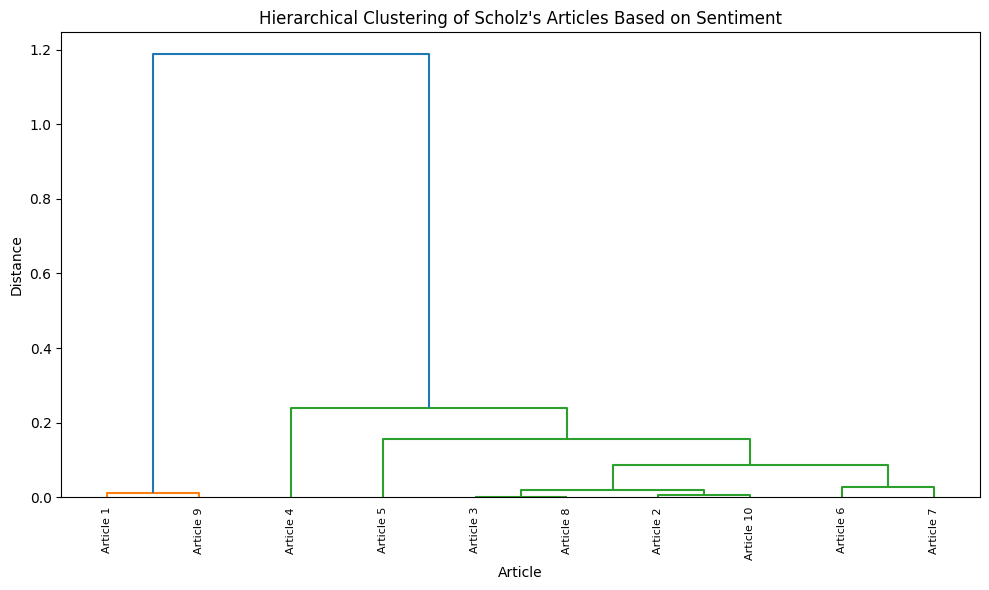



Article 1: Should Olaf Scholz Step Aside in the New Race for German Chancellor? Score: 0.2740136981010437
Article 2: Germany Pledges Fast Military Aid to Ukraine in Effort to Reassure Score: -0.3861144483089447
Article 3: Inside ‘Rail Force One’: The Trains That Take World Leaders to Ukraine Score: -0.4036780297756195
Article 4: Why Germany’s Economy, Once a Leader in Europe, Is Now in Crisis Score: -0.5418952107429504
Article 5: Putin Talks With German Chancellor, Breaking Ice With the West Score: -0.2587175965309143
Article 6: German Lawmakers Agree on Date for Snap Election in New Year Score: -0.3296401798725128
Article 7: Missing in Europe: A Strong Leader for a New Trump Era Score: -0.3569844365119934
Article 8: What the Collapse of Germany’s Ruling Coalition Means Score: -0.40306413173675537
Article 9: Trump Will Test European Solidarity on NATO, Ukraine and Trade Score: 0.28516221046447754
Article 10: Germany’s Coalition Collapses, Leaving the Government Teetering Score: -0.39

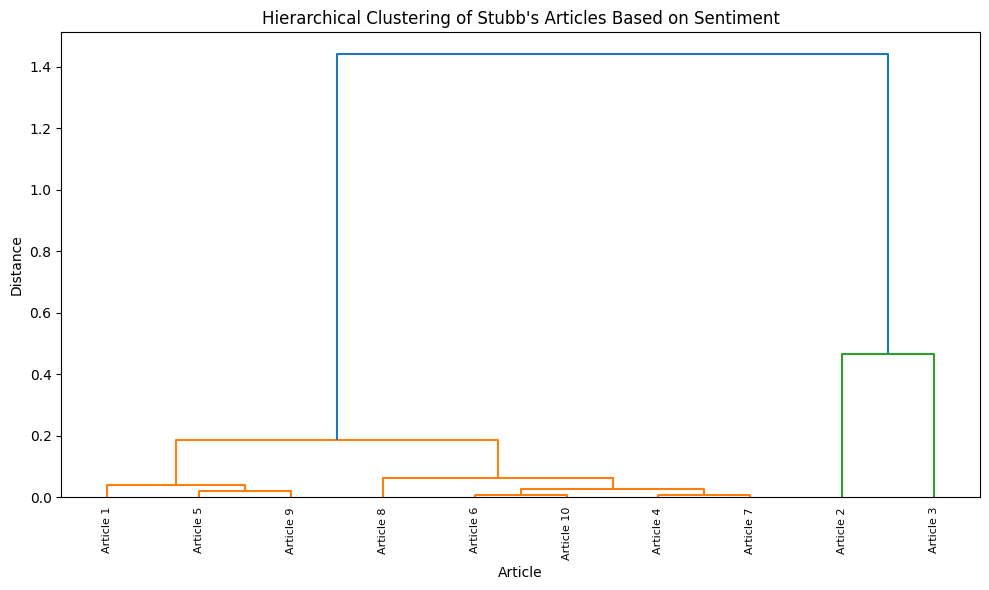



Article 1: As U.N. Meets, Pressure Mounts on Biden to Loosen Up on Arms for Ukraine Score: -0.30211132764816284
Article 2: Duke Fakir, Last Surviving Member of the Four Tops, Dies at 88 Score: 0.23252254724502563
Article 3: What to Know About Nvidia’s High-Stakes Earnings Report Score: 0.699707567691803
Article 4: Before Paris, London Showed How the Olympics Could Be Sustainable Score: -0.3788067400455475
Article 5: In Her Crisp Defense of Biden, Harris Builds a Case for Herself Score: -0.2782352566719055
Article 6: 4 Children and 2 Adults Are Killed in Ottawa Home Score: -0.3524230420589447
Article 7: Finland Passes Law to Turn Away Asylum Seekers at Border Score: -0.3704802691936493
Article 8: OpenAI Says Russia and China Used Its A.I. in Covert Campaigns Score: -0.41478201746940613
Article 9: The 84-Year-Old Visionary With One Answer for Two Real Estate Crises Score: -0.2561601996421814
Article 10: How Howard Lutnick Could Shake Up Global Trade Score: -0.35991978645324707




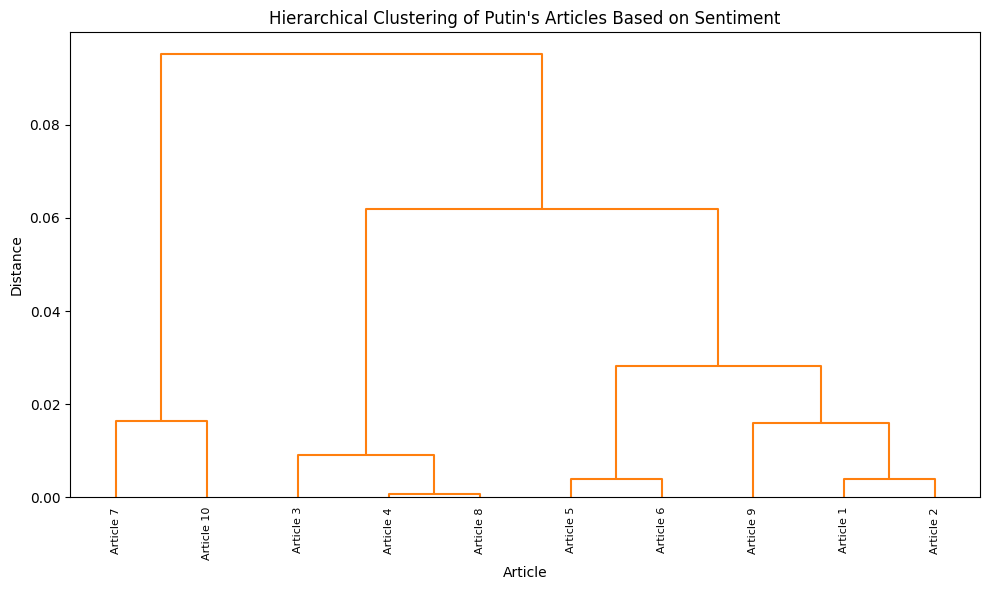



Article 1: Investigation Into Forced Adoptions From Ukraine Points Finger at Putin Score: -0.2923130989074707
Article 2: Merkel Memoir Recalls What It Was Like Dealing With Trump and Putin Score: -0.2963285446166992
Article 3: With Memes and in State Media, Many Russians Cheer on Putin’s Threats Score: -0.32885393500328064
Article 4: As Ukraine Fires U.S. Missiles, Putin Sends a Chilling Message Score: -0.32140490412712097
Article 5: Putin Sees America Hurtling to Disaster, With Trump at the Wheel Score: -0.2826579809188843
Article 6: Bitter Infighting, and Trump’s Victory, Cloud Prospects for Anti-Putin Opposition Score: -0.27876386046409607
Article 7: Putin Talks With German Chancellor, Breaking Ice With the West Score: -0.2587175965309143
Article 8: Putin Lowers Russia’s Threshold for Using Nuclear Arms Score: -0.3207322657108307
Article 9: Bogged Down in Ukraine, Russia Pays a Price in Syria Score: -0.3081895709037781
Article 10: We Cannot Forget the World’s Political Prisoners S

In [ ]:
# Install the required package
!pip install transformers

# Import necessary libraries
from transformers import pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Define your Zero-Shot Learning pipeline
zero_shot_pipeline = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define custom sentiment categories
candidate_labels = ["strongly negative", "slightly negative", "neutral", "slightly positive", "strongly positive"]

# Replace these with your actual dataframe columns
texts_scholz = df_scholz['processed_text'].tolist()  # Scholz articles
texts_stubb = df_stubb['processed_text'].tolist()    # Stubb articles
texts_putin = df_putin['processed_text'].tolist()    # Putin articles


# Extract only the 'main' field from the header_scholz list
titles_scholz = [eval(article).get('main') for article in df_scholz['headline'].tolist()]
titles_stubb = [eval(article).get('main') for article in df_stubb['headline'].tolist()]
titles_putin = [eval(article).get('main') for article in df_putin['headline'].tolist()]


# Function to map the results to sentiment scores between [-1, 1]
def map_to_sentiment_score(label, score):
    sentiment_map = {
        "strongly negative": -1,
        "slightly negative": -0.5,
        "neutral": 0,
        "slightly positive": 0.5,
        "strongly positive": 1
    }
    return sentiment_map[label] * score  # Scale by the confidence score

# Function to classify sentiment and return sentiment scores for each person
def get_sentiment_scores(texts):
    results = [zero_shot_pipeline(text, candidate_labels=candidate_labels) for text in texts]
    scores = []
    for result in results:
        best_label = result['labels'][0]  # Get the highest confidence label
        best_score = result['scores'][0]  # Get the corresponding score
        sentiment_score = map_to_sentiment_score(best_label, best_score)
        scores.append(sentiment_score)
    return scores

# Get sentiment scores for Scholz, Stubb, and Putin
scores_scholz = get_sentiment_scores(texts_scholz)
scores_stubb = get_sentiment_scores(texts_stubb)
scores_putin = get_sentiment_scores(texts_putin)

# Print the sentiment scores for each
print("Scholz Sentiment Scores:", scores_scholz)
print("\nStubb Sentiment Scores:", scores_stubb)
print("\nPutin Sentiment Scores:", scores_putin)

# Function to create and plot hierarchical clustering
def plot_hierarchical_clustering(scores, header, title):
    hier_scores = np.array(scores).reshape(-1, 1)
    Z = linkage(hier_scores, method="ward") #We use the bottom up method
    article_labels = [f"Article {i + 1}" for i in range(len(scores))]

    plt.figure(figsize=(10, 6))
    dendrogram(Z, labels=article_labels, orientation="top", color_threshold=0.5)
    plt.title(title)
    plt.xlabel("Article")
    plt.xticks(rotation=90, fontsize=8)
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

    print("\n")
    for i, label in enumerate(article_labels):
        print(f"{label}: {header[i]} --- Score: {scores[i]}")
    print("\n")


# Create and plot hierarchical clustering for Scholz, Stubb, and Putin
plot_hierarchical_clustering(scores_scholz, titles_scholz,"Hierarchical Clustering of Scholz's Articles Based on Sentiment")
plot_hierarchical_clustering(scores_stubb, titles_stubb,"Hierarchical Clustering of Stubb's Articles Based on Sentiment")
plot_hierarchical_clustering(scores_putin, titles_putin,"Hierarchical Clustering of Putin's Articles Based on Sentiment")

# **Part 3: Boxplot Politican Sentiment Score**
Now here we create a boxplot for every politican and their sentiment score. This is useful to see the averages, the minimunm and maximum and the quartiles and possible outliners. Additionally for better overview we also printed out every datapoint of the sentiment score. But it is important to mention that the Boxplot can change after a while and also the averages can change. This is because the NYT API always gives us the latest 10 articles and when a new article is

<ipython-input-14-adb0d84d8b0d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


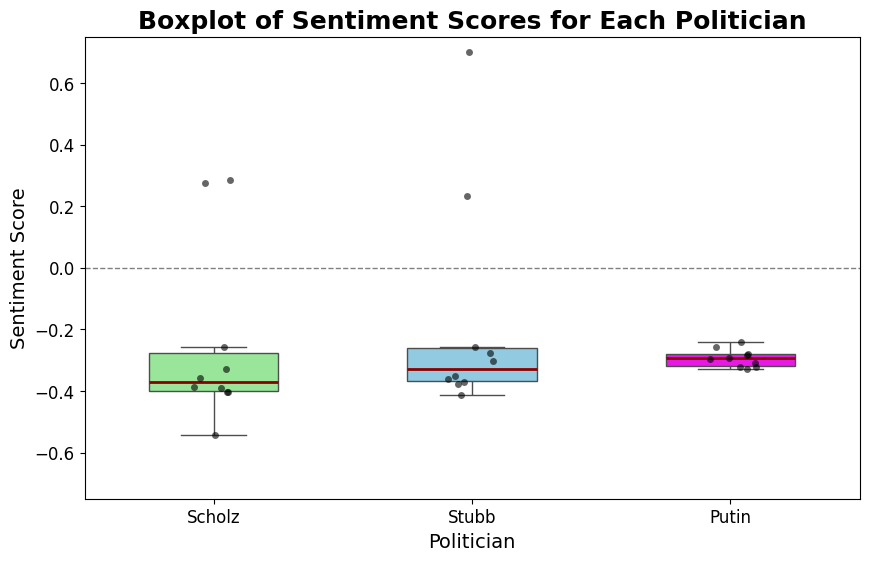


Average Sentiment Score for Scholz: -0.25127259492874143

Average Sentiment Score for Stubb: -0.1780688524246216

Average Sentiment Score for Putin: -0.2930205941200256



Highest Sentiment Score for Scholz: 0.28516221046447754

Highest Sentiment Score for Stubb: 0.699707567691803

Highest Sentiment Score for Putin: -0.2422441840171814



Lowest Sentiment Score for Scholz: -0.5418952107429504

Lowest Sentiment Score for Stubb: -0.41478201746940613

Lowest Sentiment Score for Putin: -0.32885393500328064




In [ ]:
import seaborn as sns

#Creating the boxplot over the sentiment scores for every politician
boxplot = pd.DataFrame({
    "Sentiment Score" : scores_scholz + scores_stubb + scores_putin,
    "Politician" : ["Scholz"] * len(scores_scholz) + ["Stubb"] * len(scores_stubb) + ["Putin"] * len(scores_putin)
})

plt.figure(figsize=(10, 6))


#Adjuting the boxplot
sns.boxplot(
    x="Politician",
    y="Sentiment Score",
    data=boxplot,
    palette=["lightgreen", "skyblue", "magenta"],
    saturation=0.8,
    fill=True,
    linecolor='auto',
    width=0.5,
    showfliers=False,
    medianprops={"color": "darkred", "linewidth": 2})

#Adjuting the strip plot
sns.stripplot(
    x="Politician",
    y="Sentiment Score",
    data=boxplot,
    color="black",
    alpha=0.6,
    jitter=True,
    size=5
)

#Creating the Plot
plt.title("Boxplot of Sentiment Scores for Each Politician", fontsize=18, fontweight="bold")
plt.xlabel("Politician", fontsize=14)
plt.ylabel("Sentiment Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.ylim(-0.75,0.75)
plt.show()

#Calculating the max, min and avg scores for each
avg_scores_scholz = np.mean(scores_scholz)
avg_scores_stubb = np.mean(scores_stubb)
avg_scores_putin = np.mean(scores_putin)

max_score_scholz = max(scores_scholz)
max_score_stubb = max(scores_stubb)
max_score_putin = max(scores_putin)

min_score_scholz = min(scores_scholz)
min_score_stubb = min(scores_stubb)
min_score_putin = min(scores_putin)

#Printing out the Scores with the highest, lowest and the average
print(f"\nAverage Sentiment Score for Scholz: {avg_scores_scholz}")
print(f"\nAverage Sentiment Score for Stubb: {avg_scores_stubb}")
print(f"\nAverage Sentiment Score for Putin: {avg_scores_putin}\n\n")

print(f"\nHighest Sentiment Score for Scholz: {max_score_scholz}")
print(f"\nHighest Sentiment Score for Stubb: {max_score_stubb}")
print(f"\nHighest Sentiment Score for Putin: {max_score_putin}\n\n")

print(f"\nLowest Sentiment Score for Scholz: {min_score_scholz}")
print(f"\nLowest Sentiment Score for Stubb: {min_score_stubb}")
print(f"\nLowest Sentiment Score for Putin: {min_score_putin}\n\n")